In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 5.1MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 1.2MB 8.3MB/s 
     |████████████████████████████████| 194kB 18.9MB/s 
     |████████████████████████████████| 61kB 8.5MB/s 
Mounted at /content/gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', 'dbd6b3343d0f43c68bec401c64f34059')

In [4]:
plant_types = 'succulent','cactus','tree'
path = Path('plants')

In [5]:
if not path.exists():
    path.mkdir()
    for o in plant_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o}')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [6]:
fns = get_image_files(path)
fns

(#407) [Path('plants/cactus/00000025.jpg'),Path('plants/cactus/00000015.jpg'),Path('plants/cactus/00000069.jpg'),Path('plants/cactus/00000146.jpg'),Path('plants/cactus/00000100.jpg'),Path('plants/cactus/00000077.jpg'),Path('plants/cactus/00000014.jpg'),Path('plants/cactus/00000140.jpg'),Path('plants/cactus/00000084.jpg'),Path('plants/cactus/00000132.jpg')...]

In [7]:
failed = verify_images(fns)
failed

(#3) [Path('plants/cactus/00000114.jpg'),Path('plants/cactus/00000028.jpg'),Path('plants/tree/00000147.jpg')]

In [8]:
failed.map(Path.unlink);

In [9]:
plants = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [10]:
dls = plants.dataloaders(path)

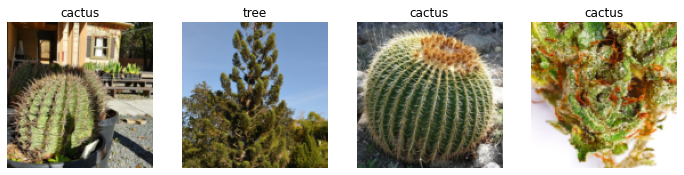

In [11]:
dls.valid.show_batch(max_n=4, nrows=1)

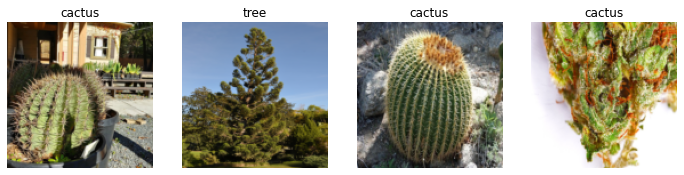

In [12]:
plants = plants.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = plants.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

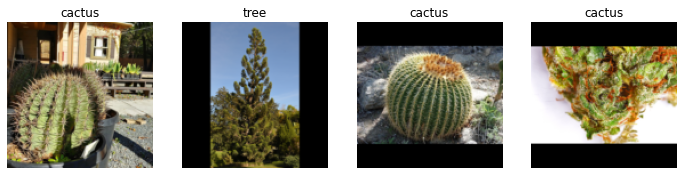

In [13]:
plants = plants.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = plants.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

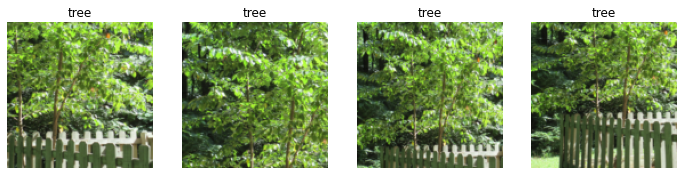

In [14]:
plants = plants.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = plants.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

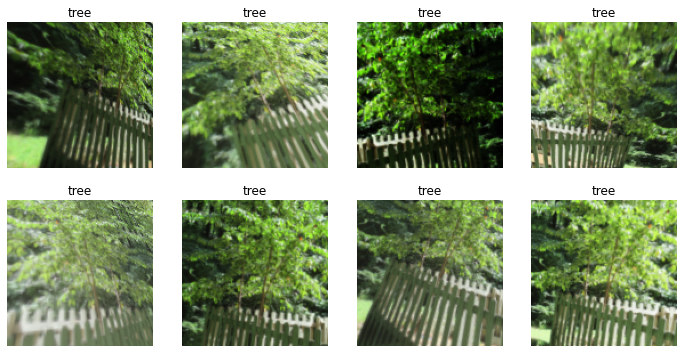

In [15]:
plants = plants.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = plants.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [16]:
plants = plants.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = plants.dataloaders(path)

In [17]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.550428,1.029377,0.337500,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.837915,0.666623,0.250000,00:11
1,0.645555,0.531009,0.225000,00:11


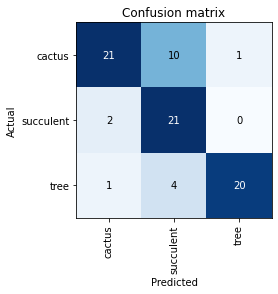

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

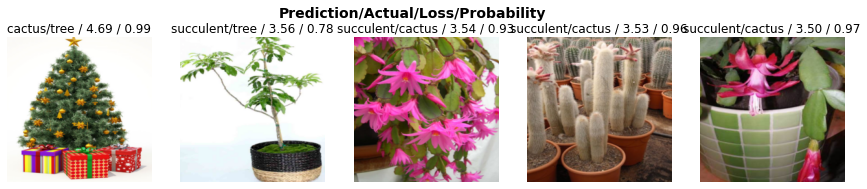

In [19]:
interp.plot_top_losses(5, nrows=1)

In [20]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [21]:
learn.export()

In [22]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [23]:
learn_inf = load_learner(path/'export.pkl')

In [35]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [37]:
img = PILImage.create(btn_upload.data[-1])

In [38]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [39]:
pred,pred_idx,probs = learn_inf.predict(img)

In [40]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: cactus; Probability: 0.9756')

In [41]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [32]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [33]:
btn_upload = widgets.FileUpload()

In [42]:
#hide_output
VBox([widgets.Label('Select your plant!'), 
      btn_upload, btn_run, out_pl, lbl_pred])